# Binary Classifier

### Compare several classifiers using the "Titanic" dataset

In [375]:
#Import the libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as seabornInstance 

from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [376]:
df =pd.read_csv("train.csv",index_col='PassengerId')

#Show the data missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [377]:
#show the data statistics
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [378]:
df.select_dtypes(include='object')


,Name,Sex,Ticket,Cabin,Embarked
PassengerId,,,,,
1,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
5,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...
887,"Montvila, Rev. Juozas",male,211536,NaN,S
888,"Graham, Miss. Margaret Edith",female,112053,B42,S
889,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S


### we have 5 categorical features. Cabin number has only 25% of non null values, and it is unlikely we can fill the null values in a way to make this category relevant, so we will just drop it. We will also drop the whole 'Ticket' and 'Name' column, and all the null values in 'Embarked'

In [379]:

df = df.drop(['Cabin','Name','Ticket'], axis=1)
df.dropna(subset=['Embarked'],inplace=True)


### we will use a custom fucntion to fill the mean age per class

In [380]:
df.groupby('Pclass')['Age'].mean()

Pclass
1    38.105543
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [381]:
def avg_age(cols):
    age = cols[0]
    p_class = cols[1]
    
    if pd.isnull(age):

        if p_class == 1:
            return 38

        elif p_class == 2:
            return 30

        else:
            return 25

    else:
        return age

In [382]:
df['Age'] = df[['Age','Pclass']].apply(avg_age,axis=1)


In [383]:
# put the labels aside
df_labels = df['Survived'].copy()
df = df.drop(['Survived'],axis=1)


In [384]:
df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

### We can treat passenger class both as a numerical or categorical variable. We will treat it as numerical for now, we may use it as an hyperparameter later.
### we now need to binarize Sex and Embarked

In [385]:
oh = LabelBinarizer()
df_sex = df[['Sex']]
df_emb = df[['Embarked']]
df_s_oh = oh.fit_transform(df_sex)
df_emb_oh = oh.fit_transform(df_emb)
df_oh = np.hstack((df_s_oh,df_emb_oh))

df_oh.shape


(889, 4)

In [386]:
df = df.drop(['Sex','Embarked'],axis=1)


In [387]:
# merge the one hot array with the numerical dataframe
result = pd.DataFrame(np.hstack([df,df_oh]))

In [388]:
# rename the columns
cols = list(df)
new_cols = ['Gender','Emb_S','Emb_C','Emb_Q']
new_ = cols+new_cols
result.columns = new_

In [389]:
# apply standard deviation scaling
scaler = StandardScaler()
result = result.copy()
df_tr = scaler.fit_transform(result)


In [390]:
#Custom function to train with seveal models
def models(X_train,Y_train):
  
  
  from sklearn.linear_model import LogisticRegression
  log = LogisticRegression(random_state = 0)
  log.fit(X_train, Y_train)
  
  
  from sklearn.neighbors import KNeighborsClassifier
  knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
  knn.fit(X_train, Y_train)


  from sklearn.svm import SVC
  svc_lin = SVC(kernel = 'linear', random_state = 0)
  svc_lin.fit(X_train, Y_train)

  from sklearn.svm import SVC
  svc_rbf = SVC(kernel = 'rbf', random_state = 0)
  svc_rbf.fit(X_train, Y_train)

  from sklearn.naive_bayes import GaussianNB
  gauss = GaussianNB()
  gauss.fit(X_train, Y_train)

  from sklearn.tree import DecisionTreeClassifier
  tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
  tree.fit(X_train, Y_train)

  from sklearn.ensemble import RandomForestClassifier
  forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
  forest.fit(X_train, Y_train)
  
  print('Model accuracy on the training data') 
  print('[0]Logistic Regression:', log.score(X_train, Y_train))
  print('[1]K Nearest Neighbor:', knn.score(X_train, Y_train))
  print('[2]Support Vector Machine (Linear Classifier):', svc_lin.score(X_train, Y_train))
  print('[3]Support Vector Machine (RBF Classifier):', svc_rbf.score(X_train, Y_train))
  print('[4]Gaussian Naive Bayes:', gauss.score(X_train, Y_train))
  print('[5]Decision Tree Classifier:', tree.score(X_train, Y_train))
  print('[6]Random Forest Classifier:', forest.score(X_train, Y_train))
  
  return log, knn, svc_lin, svc_rbf, gauss, tree, forest

### In a real life project we would use grid search or random search with cross validation on the models to find the best hyperparameters. For now we will just train and compare the models

In [391]:
#Get and train all of the models
model = models(df_tr,df_labels)

Model accuracy on the training data
[0]Logistic Regression: 0.8020247469066367
[1]K Nearest Neighbor: 0.8661417322834646
[2]Support Vector Machine (Linear Classifier): 0.7862767154105736
[3]Support Vector Machine (RBF Classifier): 0.84251968503937
[4]Gaussian Naive Bayes: 0.7851518560179978
[5]Decision Tree Classifier: 0.9808773903262092
[6]Random Forest Classifier: 0.9617547806524185


### We could investigate further by seeing which features are more relevant to our best performing model

In [392]:
m = model[5]
feat_imp = m.feature_importances_
cols = list(df)
new_cols = ['Gender','Emb_S','Emb_C','Emb_Q']
new_ = cols+new_cols
sorted(zip(feat_imp,new_),reverse=True)

[(0.30684061899297316, 'Fare'),
 (0.2905487988842091, 'Age'),
 (0.23743480312539192, 'Gender'),
 (0.07911571277222212, 'Pclass'),
 (0.0404983086691019, 'SibSp'),
 (0.018078694750238992, 'Parch'),
 (0.01765127473801362, 'Emb_Q'),
 (0.00983178806784917, 'Emb_S'),
 (0.0, 'Emb_C')]

### We can now test the model. To avoid errors, it is best to embed all the preprocessing steps in a single function. The following function will take in input only a string with the dataset filename and return two separete arrays, one with data and one with labels

In [393]:
def preprocess(str):

    df = pd.read_csv(str,index_col='PassengerId')

    df = df.drop(['Cabin','Name','Ticket'], axis=1)
    df.dropna(subset=['Embarked'],inplace=True)

    df['Age'] = df[['Age','Pclass']].apply(avg_age,axis=1)
    
    df.dropna(inplace=True)
    df_labels = df['Survived'].copy()
    df = df.drop(['Survived'],axis=1)

    oh = LabelBinarizer()
    df_sex = df[['Sex']]
    df_emb = df[['Embarked']]
    df_s_oh = oh.fit_transform(df_sex)
    df_emb_oh = oh.fit_transform(df_emb)
    df_oh = np.hstack((df_s_oh,df_emb_oh))
    df = df.drop(['Sex','Embarked'],axis=1)
    result = pd.DataFrame(np.hstack([df,df_oh]))
    
    scaler = StandardScaler()
    result = result.copy()
    df_tr = scaler.fit_transform(result)
    
    return df_tr,df_labels

In [394]:
test = 'test.csv'
X_test,y_test = preprocess(test)

In [395]:
test = pd.DataFrame(X_test)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       417 non-null    float64
 1   1       417 non-null    float64
 2   2       417 non-null    float64
 3   3       417 non-null    float64
 4   4       417 non-null    float64
 5   5       417 non-null    float64
 6   6       417 non-null    float64
 7   7       417 non-null    float64
 8   8       417 non-null    float64
dtypes: float64(9)
memory usage: 29.4 KB


In [ ]:
### We can test all the model we trained an see the results in a confusion matrix

In [396]:
from sklearn.metrics import confusion_matrix 
for i in range(len(model)):
   cm = confusion_matrix(y_test, model[i].predict(X_test)) 
   #extracting TN, FP, FN, TP
   TN, FP, FN, TP = confusion_matrix(y_test, model[i].predict(X_test)).ravel()
   print(cm)
   print('Model[{}] Testing Accuracy = "{} !"'.format(i,  (TP + TN) / (TP + TN + FN + FP)))
   print()# Print a new line

[[254  11]
 [ 17 135]]
Model[0] Testing Accuracy = "0.9328537170263789 !"

[[228  37]
 [ 28 124]]
Model[1] Testing Accuracy = "0.8441247002398081 !"

[[265   0]
 [  0 152]]
Model[2] Testing Accuracy = "1.0 !"

[[255  10]
 [ 35 117]]
Model[3] Testing Accuracy = "0.8920863309352518 !"

[[232  33]
 [ 31 121]]
Model[4] Testing Accuracy = "0.8465227817745803 !"

[[206  59]
 [ 42 110]]
Model[5] Testing Accuracy = "0.7577937649880095 !"

[[236  29]
 [ 48 104]]
Model[6] Testing Accuracy = "0.815347721822542 !"



### In this example the model that performed best on the test dataset was the second worst on the train dataset: SVM with linear classifier kernel
### We can obtain better visuals with the aid of this function from the sklearn documentation:

In [398]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[265   0]
 [  0 152]]


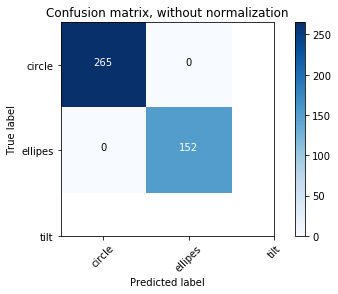

In [400]:

from sklearn.metrics import confusion_matrix 
import itertools
labels = y_test
predictions = model[2].predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, predictions)
np.set_printoptions(precision=2)
cm_labels =['circle','ellipes','tilt']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, cm_labels ,title='Confusion matrix, without normalization')